# Variable-z curvilinear topography

In this notebook, we will create a simple implementation of a cosine hill topography based on coordinate transforms. This approach to irregular topography is commonly used in industry and academia, and is based upon creating some coordinate transform which maps the curved free-surface to a horizontal, grid-coincident plane in the iteration space. The most straightforward way of achieving this is by stretching the grid in the z axis, often referred to as "variable-z". This yields a transformed wave equation which can be solved with an explict FD solver.

The isotropic acoustic wave equation in 2D is given as

$\frac{\partial^2p}{\partial t^2} = c^2\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial z^2}\right)$,

where $p$ is pressure and $c$ is wavespeed. To transform this equation from Cartesian dimensions $x$ and $z$ into a domain based on curvilinear dimensions $x'$ and $\zeta$, spatial derivatives in this equation must be replaced with their transformed equivalents. Given that only the vertical dimension is stretched, these transformed derivatives are of the form

$\frac{\partial^2p}{\partial x^2} = \frac{\partial^2p}{\partial x'^2} + \frac{\partial^2p}{\partial x'\partial \zeta}\frac{\partial\zeta}{\partial x} + \left(\frac{\partial^2 p}{\partial x' \partial\zeta}+\frac{\partial^2 p}{\partial\zeta^2}\frac{\partial\zeta}{\partial x}\right)\frac{\partial\zeta}{\partial x}+\frac{\partial p}{\partial\zeta}\frac{\partial^2\zeta}{\partial x^2}$,

and

$\frac{\partial^2p}{\partial z^2} = \frac{\partial^2 p}{\partial\zeta^2}\left(\frac{\partial\zeta}{\partial z}\right)^2$.

Note that we now have several derivatives pertaining to the transformation, $\frac{\partial\zeta}{\partial x}$ for example, which will require evaluation.

## The topography
The surface topography for this particular example corresponds to

$z_M = z_b + \frac{h\left(1 - cos\left(\frac{2\pi(x-x_m)}{w}\right)\right)}{2}$,

where $z_b$ is the baseline from which the topography rises, $h$ is the height of the topography, $x$ is the horizontal dimension with $x_m$ being its lower bound, and $w$ is the width of the domain. This surface represents the maximum extent of $z$, which will be mapped to the maximum extent of the vertical iteration dimension $\zeta$. The minimum $\zeta$, $\zeta_m$ will be mapped to $z_m$.

By constructing a linear function $\zeta(x, z)$ using these two points, derivatives of $\zeta$ with respect to these variables can be calculated. Note that the horizontal component $x'(x, z) = x$. In this case, since $z_m$ and $z_M$ are defined as above, these derivatives can be calculated analytically. In practice, more complex topographies may require calculation via finite-difference approximations.

Note that that this transformation is not a conformal mapping, simplifying this process as some of these derivatives go to zero or unity.

## The transformation

To implement our curvilinear solver, we need to know the transformation required to map the surface onto a horizontal plane, in this case the maximum of the iteration space. For simplicity, we apply a linear warping of the z dimension.

Firstly, we define a function to create a symbolic linear fit between two points:

In [1]:
import sympy as sp

def linear_fit(A, b, z):
    """Fit a linear function symbolically"""
    sol = A**-1*b
    
    # Form the function
    poly = sol[0] + sol[1]*z
    return poly

We will use this to create a function to generate symbolic expressions for $\zeta(x, z)$ and derivatives, its inverse $z(x', \zeta)$, and the equation of the surface $z_M(x)$, and return them as Python functions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def zeta_derivs():
    """
    Generates an expression for Z position of
    cosine hill of height h, with a baseline
    at z_b. Then gets functions evaluating derivatives
    of zeta with respect to x and z. Uses a linear
    warping of the z dimension to map the surface
    z_s to the maximum extent of the vertical iteration
    space.
    
    Returns
    -------
    zeta_xz : function or SymPy expression
        Zeta with respect to x and z
    zeta_dx : function or SymPy expression
        First derivative of zeta with respect to x
    zeta_dz : function or SymPy expression
        First derivative of zeta with respect to z
    zeta_dx2 : function or SymPy expression
        Second derivative of zeta with respect to x
    zeta_dz2 : function or SymPy expression
        Second derivative of zeta with respect to z
    z_zeta : function or SymPy expression
        Z with respect to zeta
    z_s : function or Sympy expression
        Z position of the surface with respect to x
    """
    # Get the cosine hill expression
    x, h, xM, xm, zb = sp.symbols('x, h, x_max, x_min, z_b')
    cos_centre = zb + h/2
    w = xM-xm  # Wavelength
    zs = cos_centre - h*sp.cos(2*sp.pi*(x-xm)/w)/2
    
    # Create the linear variable-z warp
    sym_names = """zeta_min, zeta_max, zeta, z_min, z"""
    zetam, zetaM, zeta, zm, z = sp.symbols(sym_names)

    # Set up a linear system and solve for the linear fit
    A = sp.Matrix([[1, zm],
                   [1, zs]])

    b = sp.Matrix([[zetam],
                   [zetaM]])

    poly = linear_fit(A, b, z)
    
    # Inverse of the linear warp (used for plotting)
    C = sp.Matrix([[1, zetam],
                   [1, zetaM]])
    d = sp.Matrix([[zm],
                   [zs]])

    polyinv = linear_fit(C, d, zeta)
    
    # Make a list of functions to return
    funcs = []

    # zeta(x, z) and its derivatives
    params = [x, z, xM, xm, zb, zm, zetaM, zetam, h]
    funcs.append(sp.lambdify(params, poly))  # No derivs taken
    for i in range(1, 3):  # Symbolic derivatives
        funcs.append(sp.lambdify(params, sp.diff(poly, x, i)))
        funcs.append(sp.lambdify(params, sp.diff(poly, z, i)))
    
    # z(x, zeta) to be used for plotting purposes
    paramsinv = [x, zeta, xM, xm, zb, zm, zetaM, zetam, h]
    funcs.append(sp.lambdify(paramsinv, polyinv))
        
    # Function of the surface
    paramssurf = [x, xM, xm, zb, h]
    funcs.append(sp.lambdify(paramssurf, zs))

    funcs = tuple(funcs)
    return funcs

zeta_xz, zeta_dx1, zeta_dz1, zeta_dx2, zeta_dz2, z_xzeta, z_s = zeta_derivs()

## Set up subdomains for the free surface

For an MPI-safe free surface implementation, it is necessary to set up subdomains to avoid the need for hardcoded indices. See `userapi/03_subdomains.ipynb` for more detail on this functionality.

In [3]:
from devito import SubDomain

so = 8  # Space order


class MainDomain(SubDomain):  # Main model domain
    name = 'main'
    def __init__(self, so):
        super().__init__()
        self.so = so
        
    def define(self, dimensions):
        x, zeta = dimensions
        return {x: x, zeta: ('middle', 0, 1+self.so//2)}


class FreeSurface(SubDomain):  # Free surface region
    name = 'freesurface'
    def __init__(self, so):
        super().__init__()
        self.so = so
        
    def define(self, dimensions):
        x, zeta = dimensions
        return {x: x, zeta: ('right', 1+self.so//2)}
    

main_domain = MainDomain(so)
freesurface = FreeSurface(so)

## Evaluate derivatives needed for the transform

To apply the transformation to the wave equation, the z dimension is parameterized as a function of zeta. To get the equation in terms of x and zeta, the chain rule must be applied, which yields an expression containing derivatives of zeta with respect to x and z.

As the expression for the topography is known, it is possible to evaluate these expressions algebraically and plot the curvilinear grid.

Setting up the grid to start:

In [4]:
from devito import SpaceDimension, Grid, Function

# Grid parameterisation
x_m = 0  # Minimum x (m)
x_M = 1000  # Maximum x (m)
z_m = 0  # Minimum physical z (m)
z_b = 1000  # Baseline physical z (m)
z_M = 1000  # Maximum physical z if deformation not applied (m)
zeta_m = 0  # Minimum iteration z (dimensionless)
zeta_M = 1  # Maximum iteration z (dimensionless)

h = 200  # Height of topography above baseline (m)

# Setting up the grid dimensions
x = SpaceDimension(name='x')  # Physical x
zeta = SpaceDimension(name='zeta')  # Iteration z

# Set up a grid with a square topology
grid = Grid(shape=(101, 101), extent=(x_M-x_m, zeta_M-zeta_m),
            origin=(x_m, zeta_m), dimensions=(x, zeta),
            subdomains=(main_domain, freesurface))

The functions defined earlier can now be used to evaluate the requisite derivatives pertaining to the transformation. These values will be discretized as `Function`s onto the finite-difference grid.

In [5]:
# Get surface profile
x_vals = np.linspace(x_m, x_M, grid.shape[0])
zeta_vals = np.linspace(zeta_m, zeta_M, grid.shape[1])
surface_z = z_s(x_vals, x_M, x_m, z_b, h)

# Derivatives of zeta can be precalculated
# As the surface is analytic, these can be calculated straightforwardly
# dzeta/dz is constant wrt z (only needs dimensions of y)
# dzeta2/dz2 is thus zero
zeta_dz = Function(name='zeta_dz', shape=(grid.shape[0],),
                   extent=(grid.extent[0],), origin=(x_m,),
                   dimensions=(x,))

# Z doesn't really matter here, so set to baseline value
zeta_dz.data[:] = zeta_dz1(x_vals, z_b, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

# Make an x-zeta meshgrid (for precalculating values)
x_msh, zeta_msh = np.meshgrid(x_vals, zeta_vals, indexing='ij')

# Z mesh for plotting and evaluating derivs
z_msh = z_xzeta(x_msh, zeta_msh, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

# dzeta/dx
zeta_dx = Function(name='zeta_dx', grid=grid)

zeta_dx.data[:] = zeta_dx1(x_msh, z_msh, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

# dzeta2/dx2
zeta_dxx = Function(name='zeta_dxx', grid=grid)
zeta_dxx.data[:] = zeta_dx2(x_msh, z_msh, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

Plotting the curvilinear grid:

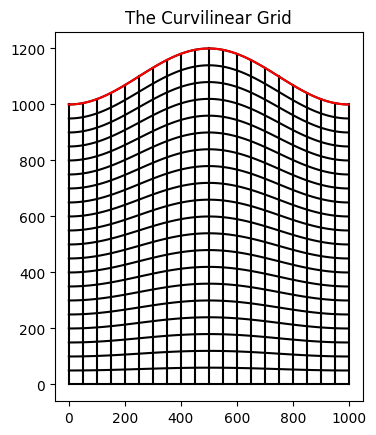

In [6]:
# Make a plot showing zeta horizons in x-z space
cells = 20  # Sets number of cells
plt.figure()
plt.title("The Curvilinear Grid")
ax = plt.gca()
ax.set_aspect('equal')
# Plot the x lines
plt.plot(x_msh[:, ::grid.shape[0]//cells], z_msh[:, ::grid.shape[1]//cells], 'k')
# Plot the zeta horizons
plt.plot(x_msh.T[:, ::grid.shape[0]//cells], z_msh.T[:, ::grid.shape[1]//cells], 'k')
# Pick out the free surface in red
plt.plot(x_vals, z_xzeta(x_vals, (zeta_M-zeta_m), x_M, x_m,
                         z_b, z_m, zeta_M, zeta_m, h), 'r')
plt.show()

## The transformed equation

Now we can write out our transformed equation. Both derivatives in the Laplacian will have modified expressions reflecting the new coordinate system.

These are substituted into the acoustic wave equation.

In [7]:
from devito import TimeFunction, Eq

# Wavespeed
c = 2.  # km/s

# Set up the TimeFunction and equations
p = TimeFunction(name="p", grid=grid, time_order=2, space_order=so)
# Transformed derivative expressions (note these are not the shortcuts)
pdx2 = p.dx2+p.dx.dzeta*zeta_dx+(p.dx.dzeta+p.dzeta2*zeta_dx)*zeta_dx+p.dzeta*zeta_dxx
pdz2 = p.dzeta2*zeta_dz**2

# Superficially resembles the untransformed equation
eq = Eq(p.forward, 2*p - p.backward + c**2*(pdx2 + pdz2),
        subdomain=grid.subdomains['main'])

## The free surface

We now implement the free surface on a horizontal plane in the iteration space by antisymmetric mirroring the pressure field across it.

In [8]:
from devito import sign, norm
from devito.symbolics import retrieve_functions, INT

def free_surface_top(eq, subdomain, function):
    """
    Modify a stencil such that it is folded back on
    itself rather than leaving the model domain. This is
    achieved by replacing the symbolic indices for some
    function of those indices.
    
    Parameters
    ----------
    eq : Eq
        The update stencil to modify
    subdomain : FreeSurface
        The subdomain in which the modification is
        applied
    function : Function
        The Function to which the folding should be
        applied
    """
    lhs, rhs = eq.evaluate.args
    
    # Get vertical subdimension and its parent
    zetafs = subdomain.dimensions[-1]
    zeta = zetafs.parent
    
    # Functions present in stencil
    funcs = retrieve_functions(rhs)
    mapper = {}
    for f in funcs:
        if f.function is function:
            # Get the zeta index
            zetaind = f.indices[-1]
            if (zetaind - zeta).as_coeff_Mul()[0] > 0:
                # Flip the sign on folded-back points
                s = sign(zetafs.symbolic_max
                         - zetaind.subs({zeta: zetafs, zeta.spacing: 1}))
                # Antisymmetric mirror
                mapper.update({f:
                               s*f.subs({zetaind: INT(zeta.symbolic_max*zeta.spacing
                                                      - abs(zeta.symbolic_max*zeta.spacing
                                                            - zetaind))})})
    return Eq(lhs, rhs.subs(mapper), subdomain=subdomain)
    
fs = free_surface_top(eq, grid.subdomains['freesurface'], p)

We can now solve this equation as any other in Devito:

In [9]:
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts a t=0
tn = 650.  # Simulation lasts 650ms
dt = grid.extent[0]/(2*c*(grid.shape[0]-1))  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.009  # Source peak frequency is 9Hz (0.009 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(grid.extent)/2  # Centre first
src.coordinates.data[0, -1] = 3*grid.extent[1]/4  # Set depth

src_term = src.inject(field=p.forward, expr=src*dt**2/c)

In [10]:
from devito import Operator

op = Operator([eq, fs] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.016083, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=1.3000000000000003e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

## Plotting the wavefield

We will first plot the wavefield in the transformed space. As we can see, the top of the wavefield is flattened, with this flattening being most pronounced at the apex of the cosine hill.

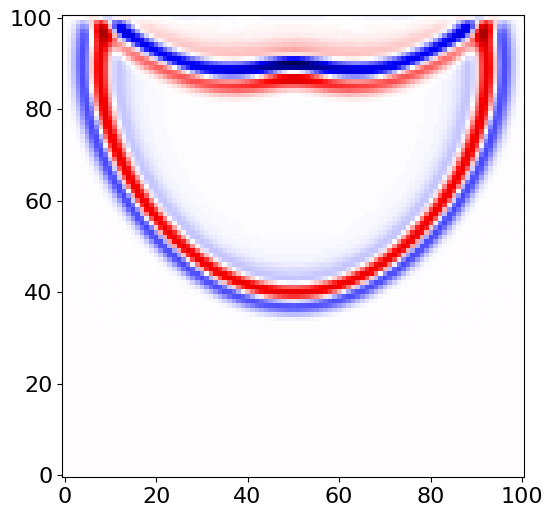

In [11]:
vmax = np.amax(np.abs(p.data[-1]))
vmin = -vmax

plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.imshow(p.data[-1].T, origin='lower', cmap='seismic',
           vmin=vmin, vmax=vmax)
plt.show()

Transforming back to physical space, the wavefront becomes circular and the focusing effect of the surface curvature becomes apparent.

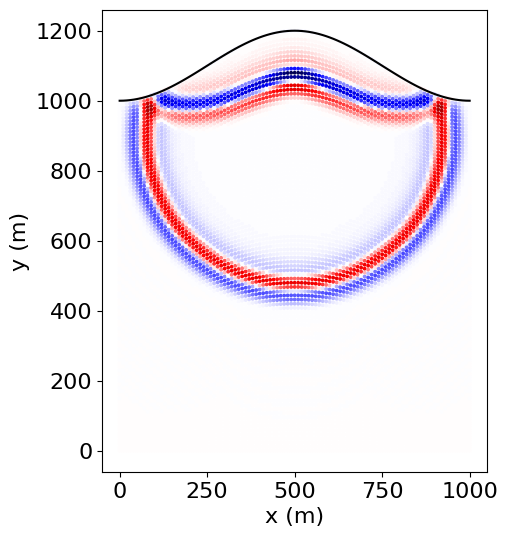

In [12]:
# Bootleg curvilinear plotter
plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(x_msh, z_msh, c=p.data[-1], s=3., cmap='seismic',
            vmin=vmin, vmax=vmax)
# Pick out the surface horizon
plt.plot(x_vals, z_xzeta(x_vals, (zeta_M-zeta_m), x_M, x_m,
                         z_b, z_m, zeta_M, zeta_m, h), 'k')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

In [13]:
np.linalg.norm(p.data)

154.39851